In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

In [8]:
# Exercise 1: Basic Feature Importance

# Step 1: Load dataset and train Random Forest

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Accuracy: 0.659375
alcohol: 0.0838
sulphates: 0.0563
volatile acidity: 0.0550
fixed acidity: 0.0194
residual sugar: 0.0131
density: 0.0119
total sulfur dioxide: 0.0119
free sulfur dioxide: 0.0088
chlorides: 0.0063
citric acid: 0.0050
pH: 0.0031


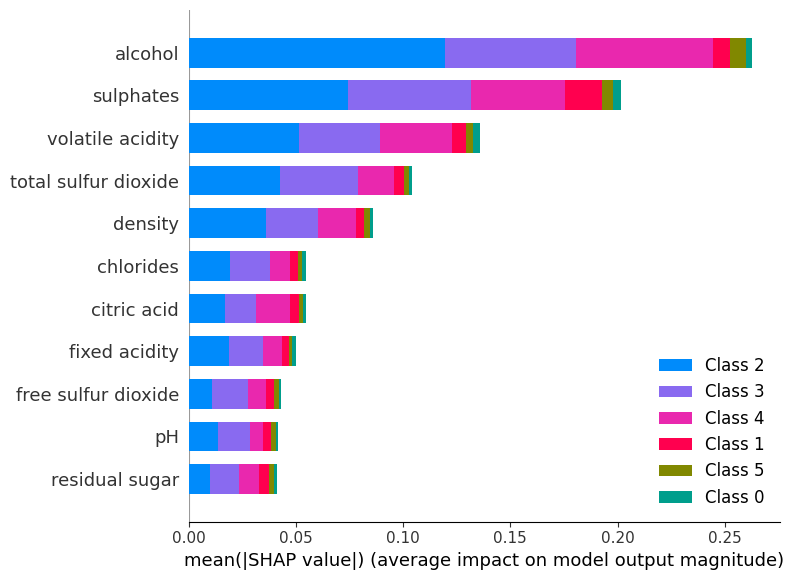

In [3]:
# Split data into features and target
X = data.drop("quality", axis=1)
y = data["quality"]

feature_names = list(X.columns)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Step 2: Calculate permutation importance

perm_importance = permutation_importance(rf_model, X_test, y_test, random_state=42)
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]}: {perm_importance.importances_mean[i]:.4f}")

# Step 3: Create SHAP summary plot and interpret the results

# Create SHAP explainer and calculate SHAP values
explainer = shap.TreeExplainer(rf_model)
# explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)

### Waterfall plots

In [4]:
shap_base_values_train = np.array(list(y_train.value_counts()))/len(y_train)

shap_base_values_test = np.array(list(y_test.value_counts()))/len(y_test)

shap_base_values_test_predict = np.array(list(pd.DataFrame(y_pred, columns=["y_pred"]).value_counts()))/len(y_pred)

print(f"Train base values: {shap_base_values_train}")
print(f"Test base values: {shap_base_values_test}")
print(f"Test predict base values: {shap_base_values_test_predict}")

Train base values: [0.43080532 0.39562158 0.12275215 0.03362002 0.01016419 0.00703675]
Test base values: [0.4125   0.40625  0.13125  0.03125  0.015625 0.003125]
Test predict base values: [0.453125 0.428125 0.109375 0.00625  0.003125]


#### Local Explanation for Sample 10 via Waterfall Plot

**E(f(x)):** Expectation for class given random feature values, based on train dataset (%occurences of class in training data)  
**f(x):** Prediction probability for individual example after adding/subtracting individual SHAP values to expectation **E(f(x))** => highest f(x) -> most likely class according to SHAP values, same as predicted class probabilities from chosen model and sample

Class 0 probability: 0.0


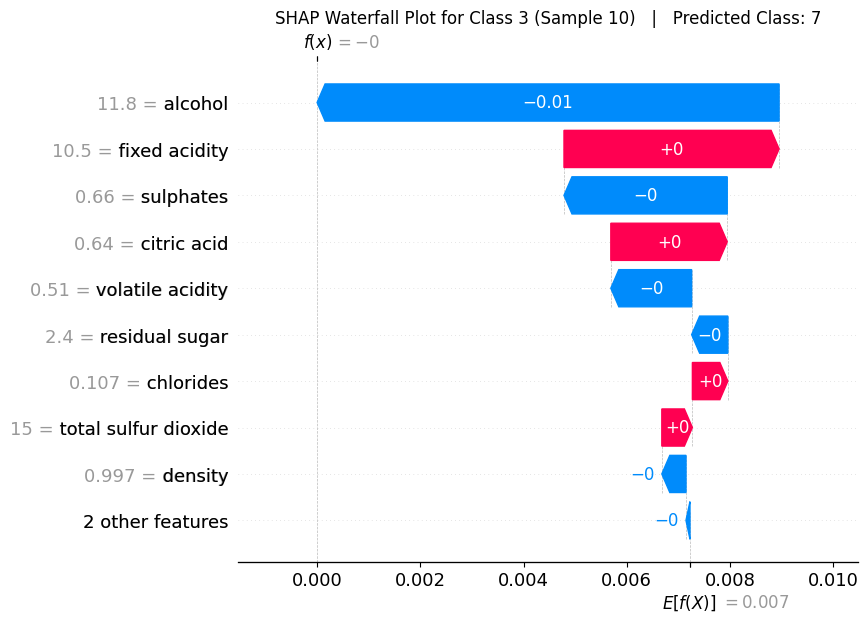

Class 1 probability: 0.0


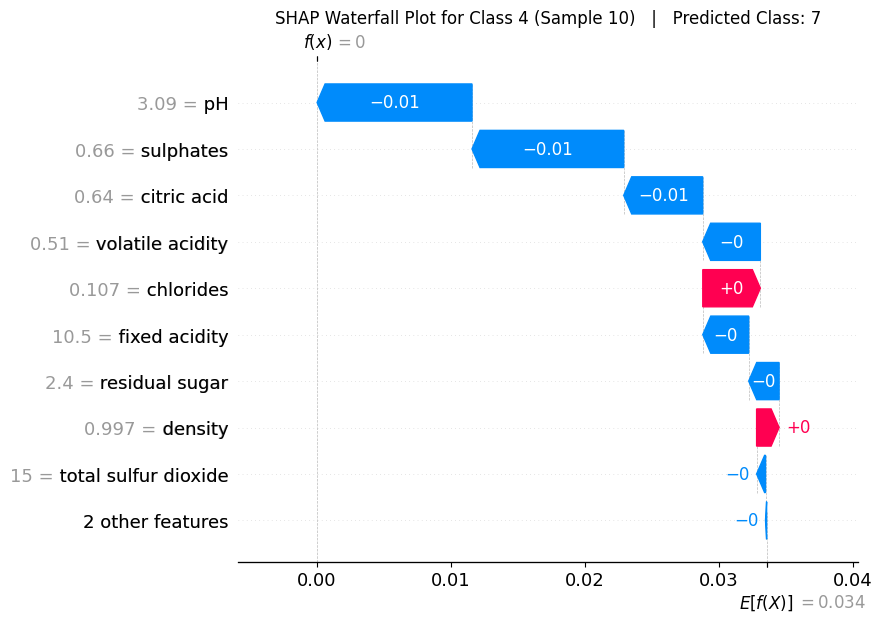

Class 2 probability: 0.01


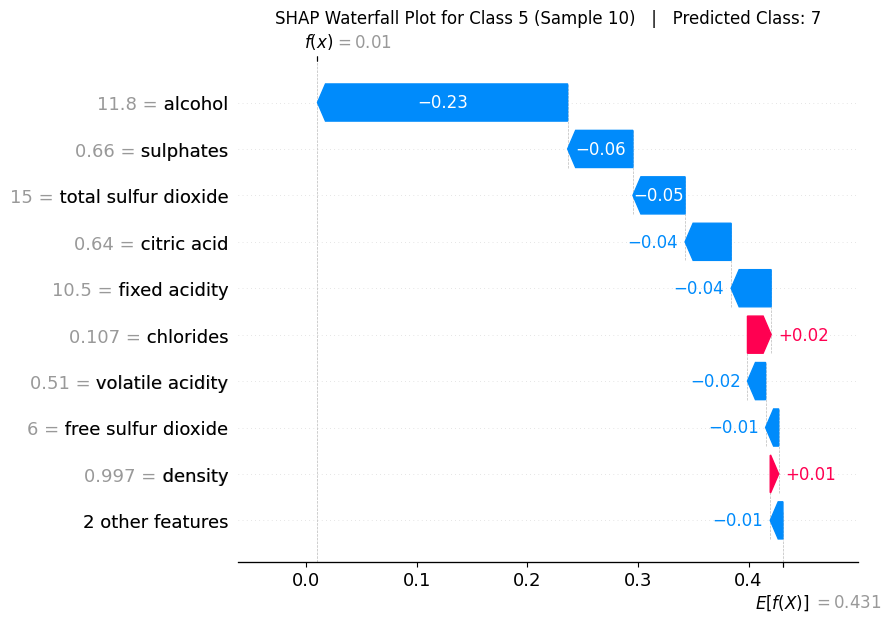

Class 3 probability: 0.26


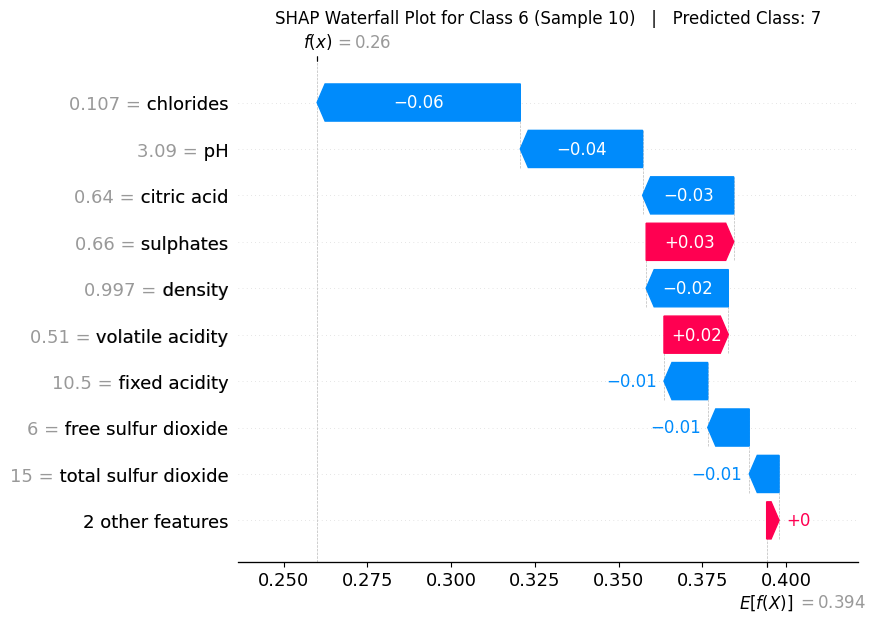

Class 4 probability: 0.71


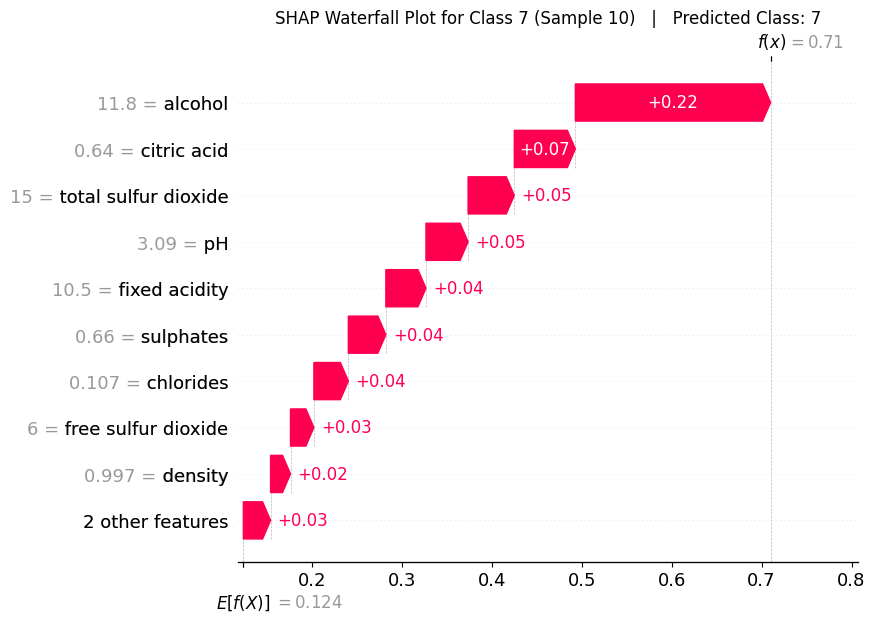

Class 5 probability: 0.02


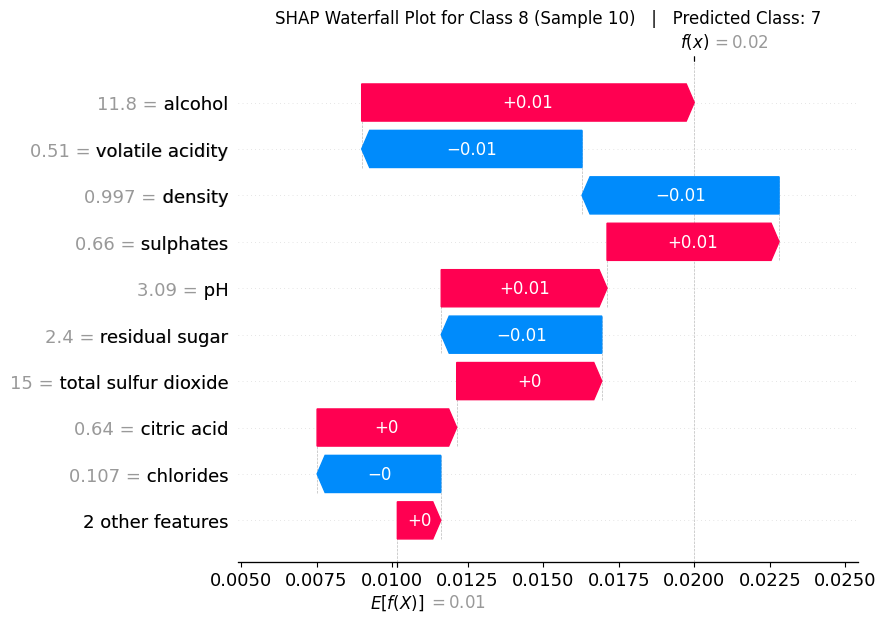

In [5]:
sample_id = 10
num_classes = shap_values.values.shape[-1]
class_offset = 3

for class_num in range(num_classes):
    print(f"Class {class_num} probability: {y_prob[sample_id][class_num]}")
    plt.title(f"SHAP Waterfall Plot for Class {class_num + class_offset} (Sample {sample_id})   |   Predicted Class: {y_pred[sample_id]}")
    shap.plots.waterfall(shap_values[sample_id,:,class_num])

### Beeswarm plots

A SHAP beeswarm plot visualizes feature importance and how individual feature values affect model output:

- Each dot represents an instance from the dataset.

- The x-axis shows the SHAP value (feature's impact on prediction).

- Color indicates the feature's value (e.g., high = red, low = blue).

- Features are ranked by importance.

In essence, it shows which features are most important and how their values influence predictions for individual instances.

You can see this below for e.g. class 5 and 7, where the feature "alcohol" leads to an increase or decrease in probabilities for both classes.

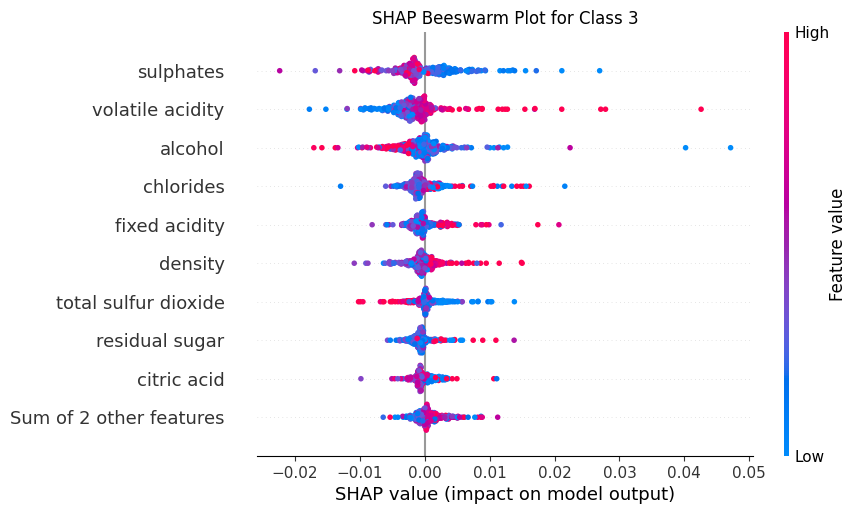

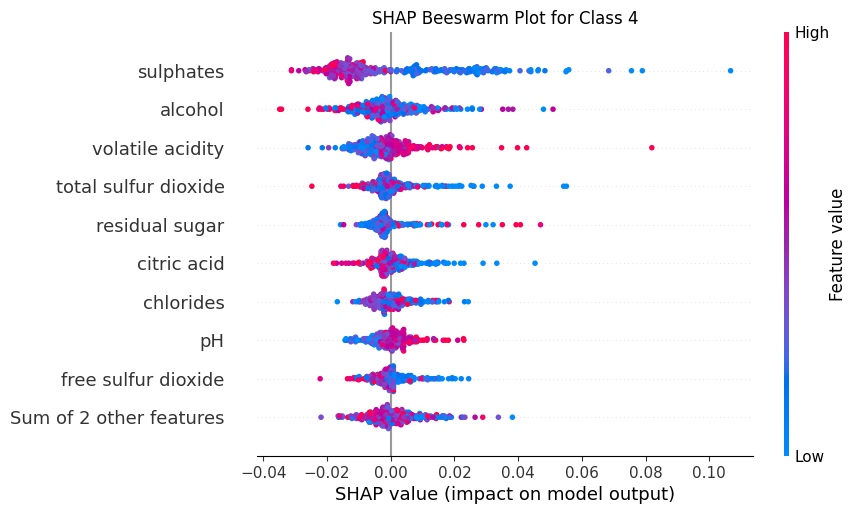

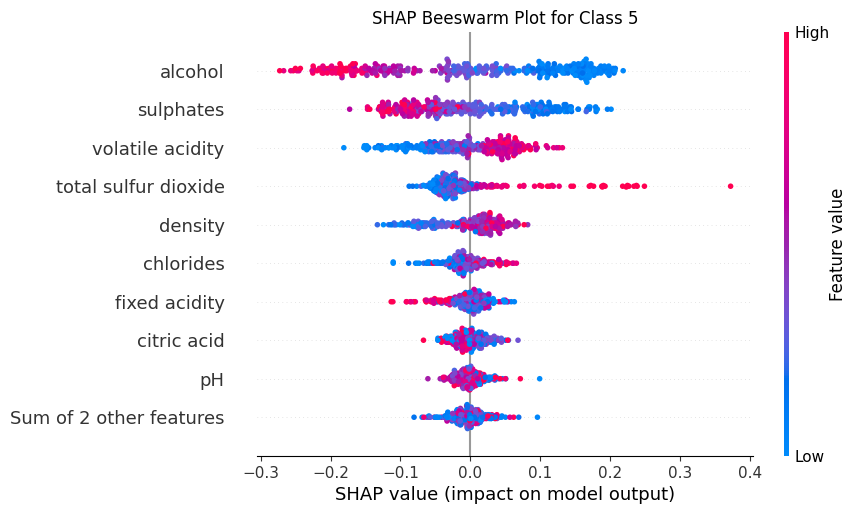

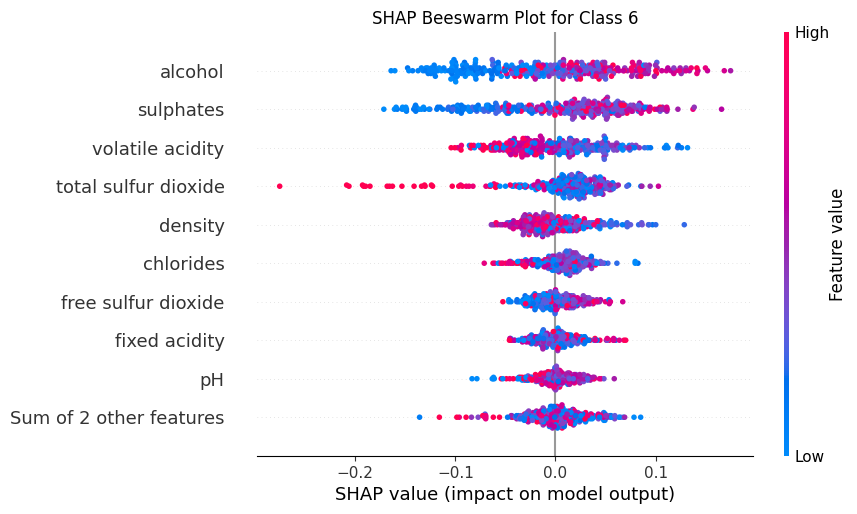

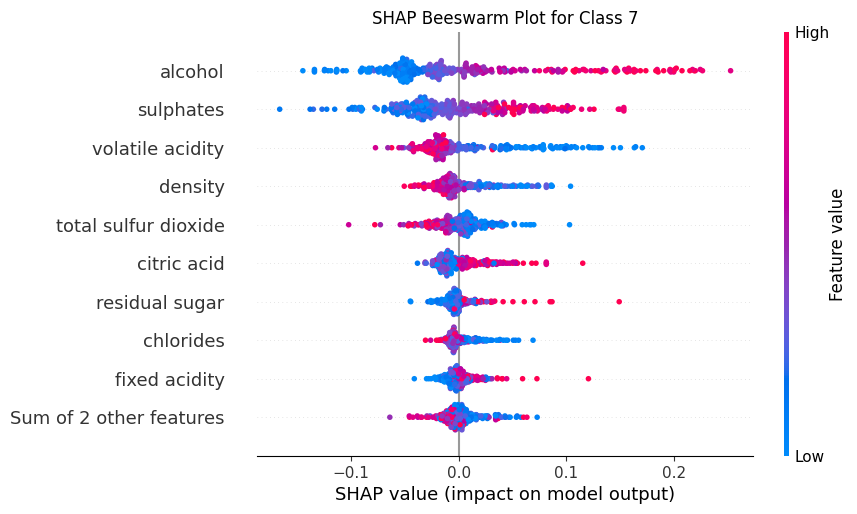

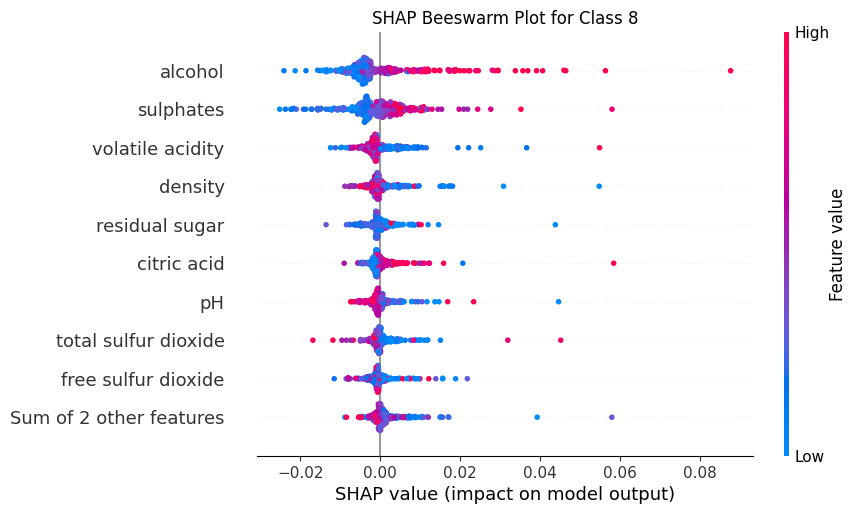

In [6]:
num_classes = shap_values.values.shape[-1]
class_offset = 3

for class_num in range(num_classes):
    plt.title(f"SHAP Beeswarm Plot for Class {class_num + class_offset}")
    shap.plots.beeswarm(shap.Explanation(shap_values[:, :, class_num], data=X_test, feature_names=feature_names))


### Explanation of Results

1. **Random Forest Classifier Accuracy**:
    - The accuracy score printed in the notebook indicates how well the Random Forest model predicts the wine quality on the test dataset (`X_test` and `y_test`).
    - A higher accuracy score suggests better performance of the model.

2. **Permutation Importance**:
    - Permutation importance measures the importance of each feature by evaluating the decrease in model performance when the feature values are randomly shuffled.
    - Features with higher importance values contribute more to the model's predictions.
    - The printed results show the importance of each feature in predicting wine quality.

3. **SHAP Summary Plot**:
    - SHAP (SHapley Additive exPlanations) values explain the impact of each feature on the model's predictions.
    - The summary plot visualizes the distribution of SHAP values for each feature, showing their importance and direction of influence (positive or negative) on the target variable (`quality`).
    - Features with larger SHAP values have a stronger influence on the predictions.

These results provide insights into the model's performance and the relative importance of features in predicting wine quality. They can guide further analysis or feature engineering to improve the model.

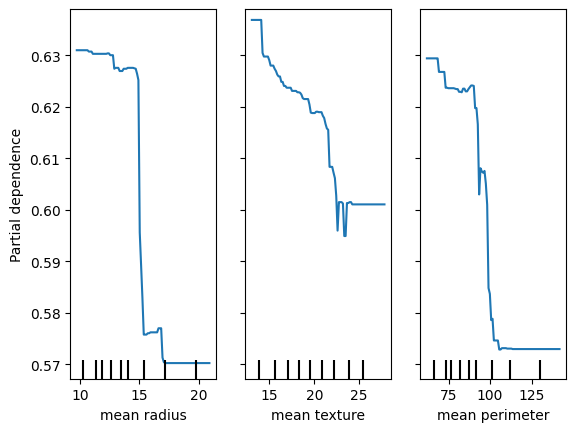

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Load the Breast Cancer Wisconsin dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Generate Partial Dependence Plots for selected features
features_to_plot = [0, 1, 2]  # Indices of features to plot (e.g., mean radius, mean texture, mean perimeter)
PartialDependenceDisplay.from_estimator(rf_model, X_test, features_to_plot, feature_names=feature_names)

# Show the plots
plt.show()

### Explanation of Results from Exercise 2

1. **Partial Dependence Plots (PDPs)**:
    - PDPs illustrate the relationship between a feature and the predicted outcome of the model, while averaging out the effects of other features.
    - In this exercise, PDPs were generated for three selected features (`mean radius`, `mean texture`, and `mean perimeter`) from the Breast Cancer dataset.
    - These plots help interpret how changes in these features influence the model's predictions.

2. **Insights from PDPs**:
    - **Feature Importance**: Features with steeper curves or significant changes in the PDPs are more influential in the model's predictions.
    - **Non-linear Relationships**: PDPs can reveal non-linear relationships between features and the target variable.
    - **Threshold Effects**: The plots may show thresholds where the feature's impact on predictions changes significantly.

3. **Model Interpretability**:
    - PDPs enhance the interpretability of the Random Forest model by providing a visual understanding of feature effects.
    - This is particularly useful for complex models like Random Forests, which are otherwise considered "black-box" models.

These results provide valuable insights into the model's behavior and the role of specific features in predicting the target variable.

### Theoretical Questions (Bonus)

#### Why might feature importance differ between permutation and SHAP?
- **Permutation Importance**:
    - Measures the decrease in model performance when a feature's values are randomly shuffled.
    - It captures the global importance of a feature based on its contribution to the model's accuracy.
    - It does not account for feature interactions explicitly.

- **SHAP (SHapley Additive exPlanations)**:
    - Based on game theory, SHAP values allocate the contribution of each feature to the prediction.
    - It considers both the main effects of a feature and its interactions with other features.
    - SHAP values provide a more nuanced explanation of feature importance, especially in the presence of feature interactions.

The difference arises because permutation importance focuses on the overall impact of a feature on model performance, while SHAP values provide a detailed breakdown of feature contributions, including interactions.

#### When would PDP be preferred over ICE plots?
- **Partial Dependence Plots (PDPs)**:
    - Show the average effect of a feature on the predicted outcome, marginalizing over other features.
    - Preferred when the goal is to understand the general trend or average relationship between a feature and the target variable.
    - Useful for simpler, global interpretations.

- **Individual Conditional Expectation (ICE) Plots**:
    - Display the effect of a feature on the predicted outcome for individual data points.
    - Preferred when analyzing heterogeneity in feature effects or when interactions between features are suspected.
    - Useful for more detailed, local interpretations.

PDPs are preferred when a global, simplified view of feature influence is sufficient, while ICE plots are better for exploring individual-level variations and interactions.


## Partial Dependence Plot (PDP) and Individual Conditional Expectation (ICE)

Here's a breakdown of ICE and PDP commonly used in Explainable AI:

### Individual Conditional Expectation (ICE) Plot

* **Goal:** Visualizes the relationship between a chosen feature and the predicted outcome for *each individual instance* in the dataset.
* **How it works:** Similar to PDP, it considers a grid of values for the chosen feature. However, instead of averaging, it plots a separate line for each instance, showing how the prediction for that specific instance changes as the feature varies.
* **Output:** A plot with multiple lines, each representing one instance and its predicted outcome across different values of the chosen feature.
* **Benefit:** Reveals heterogeneous effects and interactions that are hidden by the averaging in PDP.

### Partial Dependence Plot (PDP)

* **Goal:** Shows the average effect of one or more features on the predicted outcome of a machine learning model.
* **How it works:** For a chosen feature (or set of features), it considers a grid of values for that feature. For each value, it averages the model's predictions across all the other instances in the dataset (or a sample). E.g. 10 values per feature * 100 samples = 1000 predictions -> 10 datapoints for feature, averaged across 100 sample predictions each
* **Output:** A plot showing how the average prediction changes as the chosen feature(s) vary.
* **Limitation:** Can mask heterogeneous effects if the feature interacts strongly with other features.

### Summary Table

| Feature                      | Goal                                                                                             | How it Works                                    
**In essence:**

* **ICE:** Individual effects for each instance (Local, model-agnostic)
* **PDP:** Average effect across all instances (Global, model-agnostic)
